<a href="https://colab.research.google.com/github/ErikHartman/BMEN35/blob/2023/BMEN35_notebook_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise about sparse neural networks and SHAP values

This exercise is divided into two parts:
- Creating a sparse neural network from a graph.
- Analyzing the importance of features using SHAP (Shapley Additive Explanations)

I will leave markdown notes for where you're supposed to do something. Comments are there for your understanding and may contain minor tasks.


In [ ]:
!pip install shap
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import collections

import xgboost
import shap
shap.initjs()

from sklearn import preprocessing

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

batch_size = 128
num_epochs = 3
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292617
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.174560
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.299914
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.881947
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.812571

Test set: Average loss: 0.0046, Accuracy: 9009/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.590885
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.845336
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.402966
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.342112
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.486165

Test set: Average loss: 0.0025, Accuracy: 9424/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.348975
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.357869
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.294551
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.388856
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.399941

Test set: Average loss: 0.0018, Accuracy: 9509/10000 (95%)



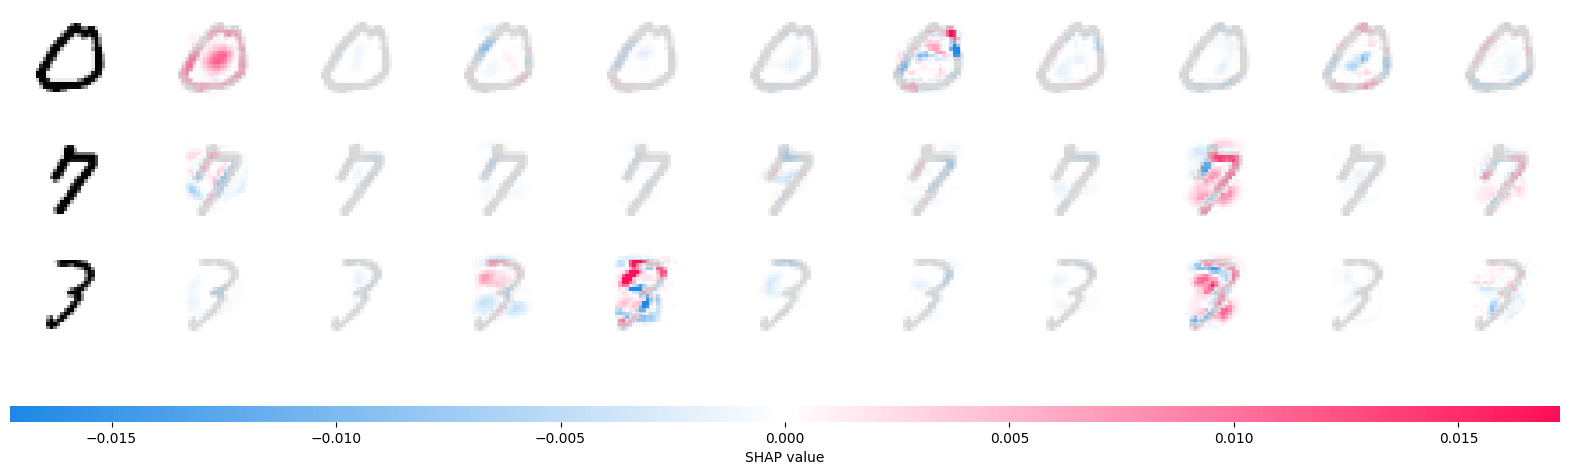

In [ ]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
"""
Read all files necessary for the notebook. These are all available in the GitHub repo.
"""
data_matrix = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/QuantMatrix.csv')
design_matrix = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/inner_design_matrix.tsv', sep="\t")
human_proteome = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/human_proteome.gz', sep=",")


In [ ]:
def get_proteins_triv_name(proteins, proteome):
  """
  This is just a function that maps UniProt IDs to more trivial names and is used later.
  """
  proteome['accession'] = proteome['accession'].apply(lambda x: x.split('_')[0])
  names = []
  for protein in proteins:
      if protein in proteome['accession'].values:
          m = proteome.loc[proteome['accession'] == protein]['trivname'].values
          assert len(m) == 1
          m = m[0].split('_')[0]
      else:
          m = protein
      names.append(m)
  return names

# Part 2

Now it's time to dive in to SHAP! This is a bit more relaxed, and you'll get to create your own pretty figures.

In [ ]:
"""
The data comes consists of a "data matrix" and a "design matrix".
The data matrix contains the actual data, whereas the design matrix contains
information about which sample is in each group.
"""

group_one_samples = design_matrix[design_matrix['group'] == 1]['sample'].values
group_two_samples = design_matrix[design_matrix['group'] == 2]['sample'].values
data_matrix.head()

,Protein,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,TM_M2012_011,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,22.381866,22.773908,22.732549,22.960530,22.906198,23.167862,23.122564,23.110142,23.179716,...,23.416677,23.498007,23.459972,23.403313,23.454894,23.602666,23.682634,23.665858,24.015710,23.655648
1,P02671,25.349974,25.431340,25.459891,25.275259,25.592789,24.829806,24.208987,23.984077,26.075865,...,24.984516,25.023149,24.971465,23.369445,24.604836,24.623221,24.787905,25.095571,25.103341,24.914344
2,P01042,22.061788,21.872170,21.966596,22.256140,22.505168,22.993978,23.277504,22.963205,22.767097,...,22.953879,23.089170,23.018547,23.280626,23.503529,23.471356,23.471414,23.193750,24.101306,23.486766
3,P00450,22.647246,23.193086,23.332780,23.206429,22.959381,23.008403,22.770807,22.971128,23.373016,...,23.788756,23.932623,23.904721,23.273831,23.462794,23.783564,23.968122,23.956618,23.989086,23.834912
4,P05156,21.301448,21.435684,21.304184,21.459141,21.532018,22.006447,21.968122,21.688934,21.372610,...,21.850530,21.883567,21.936084,21.778412,22.051000,22.187546,21.965964,21.820840,22.373783,22.076671


In [ ]:
human_proteome

,trivname,accession,seq
0,TBC9B_HUMAN,Q66K14,MWLSPEEVLVANALWVTERANPFFVLQRRRGHGRGGGLTGLLVGTL...
1,TBX20_HUMAN,Q9UMR3,MEFTASPKPQLSSRANAFSIAALMSSGGSKEKEATENTIKPLEQFV...
2,TAP26_HUMAN,Q9P031,MAPVRRSAKWRPGGIEARGEGVSTVGYRNKNVRQKTWRPNHPQAFV...
3,TBA3E_HUMAN,Q6PEY2,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
4,THYN1_HUMAN,Q9P016,MSRPRKRLAGTSGSDKGLSGKRTKTENSGEALAKVEDSNPQKTSAT...
...,...,...,...
77022,C9J167_HUMAN,C9J167,MWGRRRKLRRLNDVTISTCHASAKVGTRLMFDHNGKIIQKTPYPRP...
77023,B4DY27_HUMAN,B4DY27,MSGSKKKKVTKAERLKLLQEEEERRLKEEEEARLKYEKEEMERLEI...
77024,A0A6Q8PGL0_HUMAN,A0A6Q8PGL0,MPTAAAPIISSVQKLVLYETRARYFLVGSNNAETKYRVLKIDRTEP...
77025,D2DTW1_HUMAN,D2DTW1,MAKTPSDHLLSTLEELVPYDFEKFKFKLQNTSVQKEHSRIPRSQIQ...


In [ ]:
protein_labels = get_proteins_triv_name(data_matrix['Protein'].values, human_proteome) # the UniProt IDs are translated to more common names.

df1 = data_matrix[group_one_samples].T
df2 = data_matrix[group_two_samples].T
df1.columns = protein_labels
df2.columns = protein_labels

y = np.array([0 for x in group_one_samples] + [1 for x in group_two_samples]) # this is our Y
df_X = pd.concat([df1,df2]).fillna(0)
X = df_X.to_numpy()
scaler = preprocessing.StandardScaler().fit(X) # makes mean = 0 and variance = 1
X_scaled = scaler.transform(X) # this is our scaled X

df_X_scaled = pd.DataFrame(X_scaled) # puts everything into a pandas DataFrame
df_X_scaled.columns = df_X.columns
df_X_scaled

,CFAH,FIBA,KNG1,CERU,CFAI,CO1A1,CO7,IGLL5,TRFE,HPT,...,P01616,CTRB1,MFAP4,4F2,P18136,CSF1R,PSME1,TIMP2,FSTL3,RB27B
0,0.474120,-1.748935,0.568842,-0.554017,0.420675,-1.626960,0.474942,0.549018,1.353755,-0.247690,...,0.607345,-0.253816,-0.456284,-0.316671,-0.589943,1.354016,-0.191647,-0.535355,-0.124093,-0.071429
1,0.699739,2.301029,0.059307,0.377119,-0.145055,0.589385,-0.549855,-1.470286,-0.579473,0.178393,...,0.000225,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
2,0.616734,0.747695,0.528698,1.046836,0.078350,0.587803,-0.058332,-1.195053,0.025206,0.419302,...,-0.074833,-0.253816,2.139618,-0.316671,-0.589943,-0.708802,-0.191647,1.802819,-0.124093,-0.071429
3,1.606663,0.302478,1.550630,1.738238,0.690851,0.415007,0.303058,-1.215262,0.025584,0.617930,...,-0.029424,-0.253816,2.218473,-0.316671,-0.589943,1.175290,-0.191647,-0.535355,-0.124093,-0.071429
4,1.416180,1.772326,1.499721,1.163521,0.373920,0.255424,0.178799,-1.137548,-0.370086,0.508600,...,-0.042314,-0.253816,2.143739,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.071304,-0.511473,1.889137,1.328322,1.312417,0.696954,-0.059947,-0.007676,2.551985,-2.530578,...,-0.431806,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
193,2.330629,-0.192622,1.889287,1.755925,0.916130,0.619886,0.359412,-0.093331,2.396032,-3.784795,...,-0.151382,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
194,2.276228,0.403057,1.167853,1.729271,0.656582,0.553426,0.930050,0.198921,2.322438,-4.093601,...,0.568234,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,5.318793,-0.535355,-0.124093,-0.071429
195,3.410748,0.418100,3.525893,1.804496,1.645494,0.177873,2.182560,0.293043,1.227210,-2.100192,...,0.405155,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429


### Task 1
Now you have generated the data and put it in a dataframe. The rows in the dataframe are the samples and the columns the proteins. The values in the dataframe are the scaled protein abundances.

Now it's time to train a classifier. This time you'll use the xgboost package to train a boosted tree on the data. Implement a training algorithm and see what the accuracy is. It would be best to implement cross-validation when we have so few datapoints.

In [ ]:
from xgboost.sklearn import XGBClassifier
""" Train and test how accuarge the XGBoost model is on the data here.
Import the necessary packages. Sci-kit learn is available by default in Google Collab
so there is no need to !pip install if you're using that package. """

clf = XGBClassifier()
clf.fit(df_X_scaled, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Task 2

Now it's time to introspect the model, and see what proteins it thinks is important for the classification of very severy septic AKI and less severe septic AKI. For this we will use the SHAP package.

If you thorougly want to understand SHAP values, I recommend the original paper by Scott Lundberg:  https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf. The documentation is also very nice if you don't care about the background: https://shap-lrjball.readthedocs.io/en/latest/

I want you to create some plot which is presented in the SHAP package which visualizes what proteins are improtant in the data. The simplest plot to create is a summary plot! Feel free to explore any plots you'd like - they're all really pretty.

* NOTE: For SHAP we'd like to train a new model on the complete dataset! We don't care about validation - we just want the model to be as trained as possible.

[08:42:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


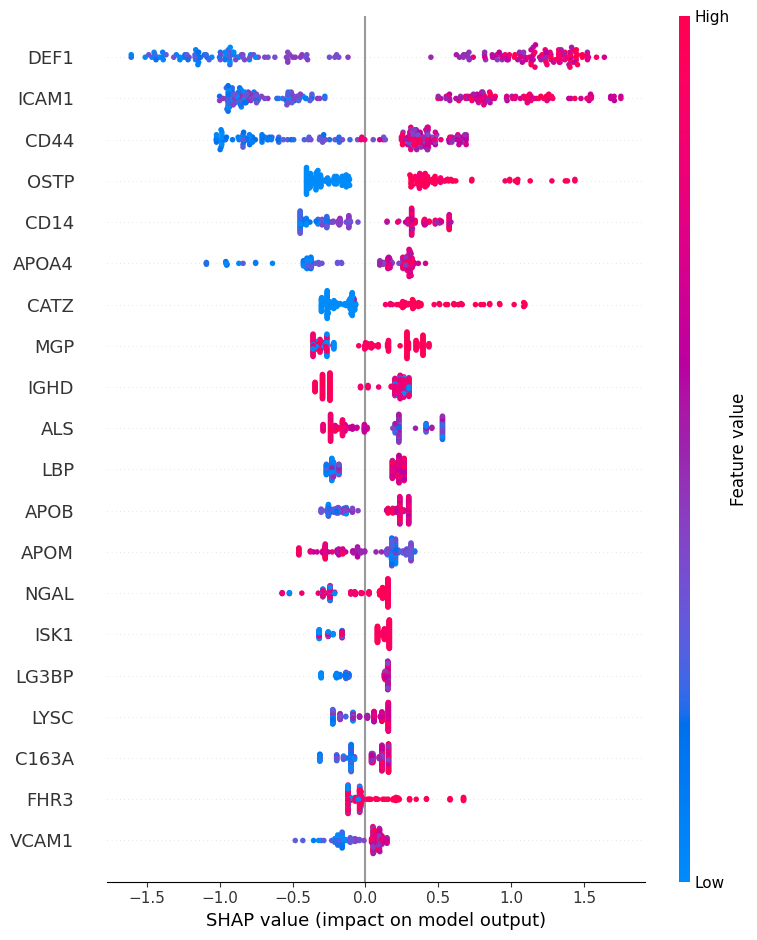

In [ ]:
""" Create some SHAP plots here! Feel free to stylize them and do whatever you'd like"""

explainer = shap.TreeExplainer(clf)
explanation = explainer(df_X_scaled)

shap_values = explanation.values
shap.summary_plot(shap_values, df_X_scaled)

#### Task 2.1
Once you've found the most important protein - look for some publications/litterature to make sense of some of the top proteins? Is the data reasonable?